In [3]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

from fastai.text import *
BOS = '_xbos_ ' 

### Read In Files From Ho-Hsiang

In [4]:
from pathlib import Path
PATH = Path('/ds/hohsiangwu/projects/semantic_search/')

with open(PATH/'train.docstring', 'r') as f:
    t_comment = f.readlines()

with open(PATH/'valid.docstring', 'r') as f:
    v_comment = f.readlines()

with open(PATH/'test.docstring', 'r') as f:
    holdout_comment = f.readlines()

### Process Files For Language Model

In [5]:
def list_flatten(l):
    "List[List] --> List"
    return [item for sublist in l for item in sublist]

- Append begininng of sentence tag 
- concatenate all text together

In [6]:
#
tok_trn = list_flatten([(BOS + x).split() for x in t_comment])
tok_val = list_flatten([(BOS + x).split() for x in v_comment])

Build Vocabulary Dict:
- index to string
- string to index
- use default dict so unknowns are mapped to zero

In [7]:
max_vocab = 30000
min_freq = 25

# index to string
freq = Counter(tok_trn) # on training set, then applied to val
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

# string to index
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

KeyboardInterrupt: 

Save Index2String Dict

In [11]:
# save itos
import pickle
with open('itos_dict.pkl', 'wb') as f:
    pickle.dump(itos, f)

Vectorize List of Strings

In [7]:
trn_lm = np.array([stoi[s] for s in tok_trn])
val_lm = np.array([stoi[s] for s in tok_val])
len(trn_lm), len(val_lm)

(67358009, 2832093)

In [8]:
# PATH = Path('/ds/hamel/CodeML/Get_Python_From_BigQuery/')
# np.save(PATH/'trn_lm.npy', trn_lm)
# np.save(PATH/'val_lm.npy', val_lm)

# Build Language Model Using Fastai  (You Can Run From Here)

In [38]:
! ls -lah code_comment_lm

total 16K
drwxr-xr-x 4 root root 6.0K Apr 24 00:13 .
drwxr-xr-x 9 1001 1001 6.0K May  3 02:30 ..
drwxr-xr-x 2 root root 6.0K Apr 30 23:21 models
drwxr-xr-x 2 root root 6.0K Apr 24 00:13 tmp


In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pickle

PATH = Path('/ds/hamel/CodeML/Get_Python_From_BigQuery/')
from fastai.text import *

trn_lm = np.load(PATH/'trn_lm.npy')
val_lm = np.load(PATH/'val_lm.npy')

with open(PATH/'lm_itos_dict.pkl', 'rb') as f:
    itos = pickle.load(f)

stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})

In [34]:
[itos[x] for x in trn_lm[:10]]

['_xbos_',
 'render',
 'this',
 'object',
 'as',
 'a',
 'dict',
 'of',
 'its',
 'fields']

In [36]:
!ls /ds/hamel/fastai/courses/dl1/code_comment_lm

models	tmp


In [2]:
PATH=Path('/ds/hamel/fastai/courses/dl1/code_comment_lm')
#PATH.mkdir(exist_ok=True)

em_sz,nh,nl = 400,400,3
wd=1e-7
bptt=20
bs=32
vs=len(itos)


with torch.cuda.device(3):
    torch.cuda.empty_cache()
    trn_dl = LanguageModelLoader(trn_lm, bs, bptt)
    val_dl = LanguageModelLoader(val_lm, bs, bptt)
    md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [3]:
with torch.cuda.device(3):
    torch.cuda.empty_cache()
    opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
    drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7
    learner= md.get_model(opt_fn, em_sz, nh, nl, 
                            dropouti=drops[0], 
                            dropout=drops[1], 
                            wdrop=drops[2], 
                            dropoute=drops[3], 
                            dropouth=drops[4])
    lr=1e-3
    lrs = lr
    #learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

In [4]:
lr = 1e-3 / 2

In [ ]:
'code_comment_lm_v3.fai'

In [5]:
with torch.cuda.device(3):
    learner.fit(lrs, 1, wds=wd, cycle_len=3, use_clr=(32,10))

  1%|          | 644/105245 [00:20<55:05, 31.64it/s, loss=6.32]  

KeyboardInterrupt: 

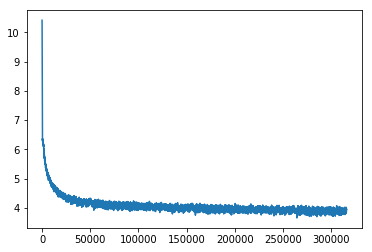

In [6]:
learner.sched.plot_loss()

In [7]:
# learner.save('code_comment_lm_v3.fai')
# learner.save_encoder('code_comment_lm_encoder_v3.fai')

In [6]:
learner.load('code_comment_lm_v3.fai')

  1%|          | 644/105245 [00:40<1:48:17, 16.10it/s, loss=6.32]

# Vectorize All Comments (Create Universal Sent Encoder For Comments)

In [7]:
import pickle
import collections

with open('itos_dict.pkl', 'rb') as f:
    itos = pickle.load(f)

In [10]:
from pathlib import Path
PATH = Path('/ds/hohsiangwu/projects/semantic_search/')

with open(PATH/'train.docstring', 'r') as f:
    t_comment = f.readlines()

with open(PATH/'valid.docstring', 'r') as f:
    v_comment = f.readlines()

with open(PATH/'test.docstring', 'r') as f:
    holdout_comment = f.readlines()


# The reason you are rebuilding this is that the data fed into the language model was completely flattened and
#  concatenated, whereas here you want to maintain the list of 
tok_trn_list = [(BOS + x).split() for x in t_comment]
tok_val_list = [(BOS + x).split() for x in v_comment]
tok_hld_list = [(BOS + x).split() for x in holdout_comment]

In [11]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})

In [12]:
idx_trn_list = [[stoi[a] for a in x] for x in tok_trn_list]
idx_val_list = [[stoi[a] for a in x] for x in tok_val_list]
idx_hld_list = [[stoi[a] for a in x] for x in tok_hld_list]

In [17]:
import numpy as np

def list2arr(l):
    "Convert list into pytorch Variable."
    return V(np.expand_dims(np.array(l), -1)).cpu()

def make_prediction_from_list(model, l):
    """
    Encode a list of integers that represent a sequence of tokens.  The
    purpose is to encode a sentence or phrase.
    
    Parameters
    -----------
    model : fastai language model
    l : list
        list of integers, representing a sequence of tokens that you want to encode
        
    """
    #with torch.cuda.device(3):
    arr = list2arr(l)# turn list into pytorch Variable with bs=1
    model.reset()  # language model is stateful, so you must reset upon each prediction
    hidden_states = model(arr)[-1][-1] # RNN Hidden Layer output is last output, and only need the last layer
    
    #return avg-pooling, max-pooling, and last hidden state
    return hidden_states.mean(0), hidden_states.max(0)[0], hidden_states[-1]

In [24]:
def get_embeddings(lm_model, list_list_int):
    """
    Vectorize a list of sequences List[List[int]] using a fast.ai language model. 
    
    Paramters
    ---------
    lm_model : fastai language model
    list_list_int : List[List[int]]
        A list of sequences to encode
        
    Returns
    -------
    tuple: (avg, mean, last)
        A tuple that returns the average-pooling, max-pooling over time steps as well as the last time step.
    """
    avg_embs, mean_embs, last_embs = [], [], []

    for i in tqdm_notebook(range(len(list_list_int))):
        avg_, max_, last_ = make_prediction_from_list(lm_model, list_list_int[i])
        avg_embs.append(avg_)
        mean_embs.append(max_)
        last_embs.append(last_)
    
    return torch.cat(avg_embs), torch.cat(mean_embs), torch.cat(last_embs)

In [39]:
learner.load('code_comment_lm_v3.fai')
learner.model.eval() # make sure dropout and bn are not activated during prediction
learner.model.cpu()
#train_avg_emb, train_mean_emb, train_last_emb = get_embeddings(learner.model.cpu(), idx_trn_list)

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(33243, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(33243, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 400, dropout=0.105)
      )
      (1): WeightDrop(
        (module): LSTM(400, 400, dropout=0.105)
      )
      (2): WeightDrop(
        (module): LSTM(400, 400, dropout=0.105)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=33243, bias=False)
    (dropout): LockedDropout(
    )
  )
)

In [28]:
#PATH = Path('/ds/hamel/CodeML/Get_Python_From_BigQuery/')

In [40]:
# torch.save(train_avg_emb, PATH/'train_avg_emb.torchtensor')
# torch.save(train_mean_emb, PATH/'train_max_emb.torchtensor') #supposed to be max, not mean!
# torch.save(train_last_emb, PATH/'train_last_emb.torchtensor')

In [45]:
# np.save(PATH/'train_avg_emb.npy', train_avg_emb.data.numpy())
# np.save(PATH/'train_max_emb.npy', train_mean_emb.data.numpy())
# np.save(PATH/'train_last_emb.npy', train_last_emb.data.numpy())

In [49]:
# val_avg_emb, val_max_emb, val_last_emb = get_embeddings(learner.model.cpu(), idx_val_list)

In [50]:
# torch.save(val_avg_emb, PATH/'val_avg_emb.torchtensor')
# torch.save(val_max_emb, PATH/'val_max_emb.torchtensor') #supposed to be max, not mean!
# torch.save(val_last_emb, PATH/'val_last_emb.torchtensor')

In [51]:
# np.save(PATH/'val_avg_emb.npy', val_avg_emb.data.numpy())
# np.save(PATH/'val_max_emb.npy', val_max_emb.data.numpy())
# np.save(PATH/'val_last_emb.npy', val_last_emb.data.numpy())

The concatenation, etc of these vectors are continued in the CPU notebook.

# Save Lang Model Artificacts

In [52]:
# import pickle
# PATH = Path('/ds/hamel/CodeML/Get_Python_From_BigQuery/')

# with open(PATH/'lm_itos_dict.pkl', 'wb') as f:
#     pickle.dump(itos, f)

In [54]:
lm_fastai_codecomment_model = learner.model.cpu()

PATH = Path('/ds/hamel/CodeML/Get_Python_From_BigQuery/')
torch.save(lm_fastai_codecomment_model, PATH/'lm_fastai_codecomment_model.pytorch')

In [80]:
# Test the model


#notice all the stuff you have to do to make sure its on cpu

# x_arr = np.expand_dims(np.array(idx_val_list[0]), -1)
# test_model.eval()
# results = test_model(V(T(x_arr)).cpu())
# test_model.reset()

In [41]:
lm_fastai_codecomment_model = learner.model.cpu()
PATH = Path('/ds/hamel/CodeML/Get_Python_From_BigQuery/')
torch.save(lm_fastai_codecomment_model.state_dict(), PATH/'lm_fastai_codecomment_model_state_dict.pytorch')

In [8]:
test_dict = torch.load(PATH/'lm_fastai_codecomment_model_state_dict.pytorch')

In [15]:
learner.model.load_state_dict(test_dict)

In [16]:
learner.model.eval() # make sure dropout and bn are not activated during prediction
test_model = learner.model.cpu()

In [17]:
test_model

SequentialRNN(
  (0): RNN_Encoder(
    (encoder): Embedding(33243, 400, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(33243, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDrop(
        (module): LSTM(400, 400, dropout=0.105)
      )
      (1): WeightDrop(
        (module): LSTM(400, 400, dropout=0.105)
      )
      (2): WeightDrop(
        (module): LSTM(400, 400, dropout=0.105)
      )
    )
    (dropouti): LockedDropout(
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
      (2): LockedDropout(
      )
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=33243, bias=False)
    (dropout): LockedDropout(
    )
  )
)

In [22]:
test_model.reset()
test_model(V(T(np.expand_dims(trn_lm[0:10], -1))).cpu())

(Variable containing:
 -1.9948e-01 -6.0683e+00 -1.6551e+00  ...  -6.0885e+00 -6.0862e+00 -6.0683e+00
  1.9821e+00 -5.8145e+00  7.9009e-01  ...  -5.8813e+00 -5.8475e+00 -5.8146e+00
  3.8231e-01 -8.7099e+00 -1.1992e+00  ...  -8.7257e+00 -8.7168e+00 -8.7099e+00
                 ...                   ⋱                   ...                
  6.6529e-01 -9.1462e+00 -1.7246e+00  ...  -9.1607e+00 -9.1521e+00 -9.1462e+00
 -1.5618e-01 -9.9707e+00 -4.2412e+00  ...  -9.9758e+00 -9.9622e+00 -9.9707e+00
  3.1648e+00 -7.1095e+00  9.1025e+00  ...  -7.1357e+00 -7.1131e+00 -7.1095e+00
 [torch.FloatTensor of size 10x33243], [Variable containing:
  ( 0 ,.,.) = 
   -3.3752e-02 -5.8660e-01  3.0104e-03  ...  -4.3180e-03  1.9405e-04 -5.8076e-04
  
  ( 1 ,.,.) = 
    6.9109e-02 -7.8205e-03 -1.5085e-01  ...  -6.8334e-03 -8.9473e-04  6.3504e-02
  
  ( 2 ,.,.) = 
    8.2495e-05  6.2996e-02 -8.6196e-02  ...   5.4503e-03  1.2820e-02  7.6637e-06
  ... 
  
  ( 7 ,.,.) = 
    1.8740e-04 -2.6275e-02 -1.9584e-02  ...  

In [9]:
V(T(np.expand_dims(trn_lm[0:10], -1))).cpu()

Variable containing:
    2
  566
   18
   40
   36
    5
  108
    7
  144
  250
[torch.LongTensor of size 10x1]